In [8]:
!pip install gymnasium
import gymnasium as gym
from collections import namedtuple, deque
from itertools import count
import argparse
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from IPython.display import clear_output

runName = "Dueling"
runNo = 0

In [9]:
def select_action(state, env, policy_net, steps_done, eps_start, eps_end, eps_decay, device):
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1), eps_threshold
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold

In [10]:
def plot_durations(durations, rewards, epsilon_change, show_result=False):
    clear_output(True)
    fig, axis = plt.subplots(3)
    fig.set_figwidth(7)
    fig.set_figheight(7)
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    epsilons_t = torch.tensor(epsilon_change, dtype=torch.float)
    durations_t = torch.tensor(durations, dtype=torch.float)
    if show_result:
        fig.suptitle('Result')
    else:
        axis[0].cla()
        axis[1].cla()
        axis[2].cla()
        fig.suptitle('Training...')
        
    axis[0].set_xlabel('Episode')
    axis[0].set_ylabel('Reward')
    axis[0].plot(rewards_t.numpy(), label=f'lr={args.lr},gamma={args.gamma},decayrate={args.eps_decay},batch_size={args.batch_size}')
    axis[0].legend(loc="upper right")

    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axis[0].plot(means.numpy())

    axis[1].set_xlabel('Episode')
    axis[1].set_ylabel('Duration')
    axis[1].plot(durations_t.numpy(), label=f'lr={args.lr},gamma={args.gamma},decayrate={args.eps_decay},batch_size={args.batch_size}')
    axis[1].legend(loc="upper right")

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axis[1].plot(means.numpy())

    axis[2].set_xlabel('Episode')
    axis[2].set_ylabel('Epsilon')
    axis[2].plot(epsilons_t.numpy(), label=f'lr={args.lr},gamma={args.gamma},decayrate={args.eps_decay},batch_size={args.batch_size}')
    axis[2].legend(loc="upper right")
    
    plt.tight_layout() 
    plt.pause(0.001)

In [11]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.feature_layer=nn.Sequential(
            nn.Linear(n_observations,128),
            nn.ReLU(),
        )
        self.advantage_layer=nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_actions),
        )
        self.value_layer=nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1),
        )


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        feature=self.feature_layer(x)
        value=self.value_layer(feature)
        advantage=self.advantage_layer(feature)

        q=value+advantage-advantage.mean(dim=-1,keepdim=True)
        return q

In [12]:
class ReplayMemory(object):

    def __init__(self, capacity, transition):
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
def optimize_model(memory, transition, policy_net, target_net, optimizer, gamma, batch_size, device):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

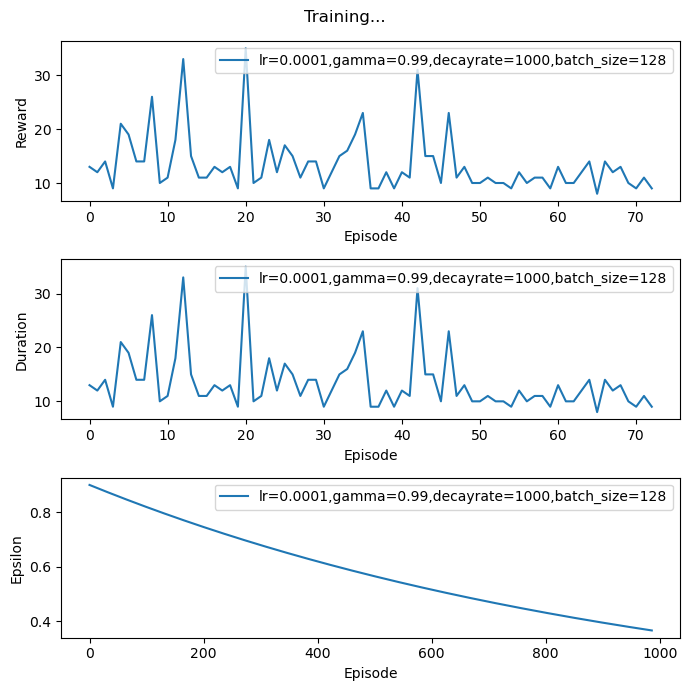

Training:   7%|▋         | 73/1000 [00:35<07:30,  2.06it/s]


KeyboardInterrupt: 

In [14]:
    parser = argparse.ArgumentParser()
    parser.add_argument('-e', '--num-episodes', type=int, default=1000,help="set number of training episodes")
    parser.add_argument('-b', '--batch-size', type=int, default=128, help="set training batch size (i.e., the number of experiences sampled from the replay memory)")
    parser.add_argument('-g', '--gamma', type=float, default=0.99, help="set the discount factor")
    parser.add_argument('--eps-start', type=float, default=0.9, help="set the initial value of epsilon")
    parser.add_argument('--eps-end', type=float, default=0.05, help="set the final value of epsilon")
    parser.add_argument('--eps-decay', type=float, default=1000, help="set the rate of exponential decay of epsilon (higher meaning a slower decay)")
    parser.add_argument('--tau', type=float, default=0.005, help="set the update rate of the target network")
    parser.add_argument('--lr', type=float, default=1e-4, help="set the learning rate")

    # Parse given arguments
    args, unknown = parser.parse_known_args()

    # Get available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Make the CartPole environment
    env = gym.make("CartPole-v1")

    # Get the number of actions from gym action space
    n_actions = env.action_space.n

    # Get the number of state observations
    state, info = env.reset()
    n_observations = len(state)

    # Build the networks
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # Build optimizer (AdamW)
    optimizer = optim.AdamW(policy_net.parameters(), lr=args.lr, amsgrad=True)

    # Build Replay Memory
    transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
    memory = ReplayMemory(10000, transition=transition)

    # Training loop
    steps_done = 0
    rewards = []
    episode_durations = []
    epsilon_array = []
    for i_episode in tqdm(range(args.num_episodes), desc="Training: "):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_rewards = 0
        for t in count():
            action, eps = select_action(state, env, policy_net, steps_done, args.eps_start, args.eps_end, args.eps_decay, device)
            epsilon_array.append(eps)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_rewards += reward
            done = terminated or truncated

            steps_done += 1

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(memory, transition, policy_net, target_net, optimizer, args.gamma, args.batch_size, device)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * args.tau + target_net_state_dict[key] * (1 - args.tau)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                rewards.append(episode_rewards)
                plot_durations(episode_durations, rewards, epsilon_array)
                break

    plot_durations(episode_durations, rewards, epsilon_array, show_result=True)
    plt.ioff()
    plt.show()
    runNo += 1
    fileName = runName + str(runNo)
    plt.savefig(fileName)